# Installation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import optuna
import torch
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm, trange
import datasets
import pandas as pd
from map_boxes import mean_average_precision_for_boxes
from datasets import Dataset, DatasetDict
from blur.backend.config import CUSTOM_FACE_PATH, DATA_PATH, CASCADE_XML
from blur.backend.utils import seed_everything, prepare_dfs
from blur.backend.drawing import draw_predicted_bboxes
from blur.backend.models import Cascade

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [3]:
dataset = datasets.load_from_disk(str(CUSTOM_FACE_PATH))

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'faces'],
        num_rows: 6423
    })
    validation: Dataset({
        features: ['image', 'faces'],
        num_rows: 1537
    })
})

# OpenCV-Baseline

В качестве основы можно рассмотреть нестандартное техническое решение от OpenCV, которое работает на основе каскада слабых классификаторов (функций Хаара).\
Пример того, как они выглядят, ниже:

<div style="text-align: center;">
  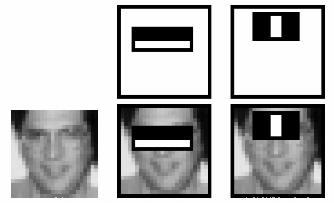
</div>

Они представляют собой черно-белые паттерны, которые были получены на большом количестве данных для решения этой задачи.\
Важно понимать, что не каждый такой паттерн имеет смысл для интерпретации. Далее цитата из оригинальной статьи:
```
В верхнем ряду показаны две хорошие особенности. Кажется, что первый выбранный признак фокусируется на том свойстве, что область глаз часто темнее, чем область носа и щек. Второй выбранный признак основан на том свойстве, что глаза темнее переносицы. Но те же окошки, нанесенные на щеки или любое другое место, не имеют значения. Так как же нам выбрать лучшие функции из более чем 160 000 функций? Это достигается с помощью Adaboost.
```
Прочитать подробнее про Adaboost можно [здесь](https://habr.com/ru/companies/otus/articles/503888/) \
Прочитать подробнее про метод можно [здесь](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [22]:
cascade = Cascade()

predictions = []
split = "validation"
for idx in trange(len(dataset[split])):
    img = np.array(dataset[split][idx]['image'])
    
    faces = cascade.predict(
        images=np.expand_dims(img, 0), 
        idx=np.array([idx]),
    )
    predictions.extend(faces)

predictions = pd.DataFrame(predictions)

100%|███████████████████████████████████████| 1537/1537 [03:30<00:00,  7.31it/s]


In [6]:
dfs = prepare_dfs(dataset)

In [7]:
original_cols = ['img_id', 'label', 'xmin', 'xmax', 'ymin', 'ymax']
preds_cols = ['img_id', 'label', "confidence", 'xmin', 'xmax', 'ymin', 'ymax']
mean_ap, average_precisions = mean_average_precision_for_boxes(
    dfs["validation"][original_cols].values,
    predictions[preds_cols].values,
)

Number of files in annotations: 1537
Number of files in predictions: 1083
Unique classes: 1
Detections length: 1083
Annotations length: 1537
face                           | 0.218817 |    1952
mAP: 0.218817


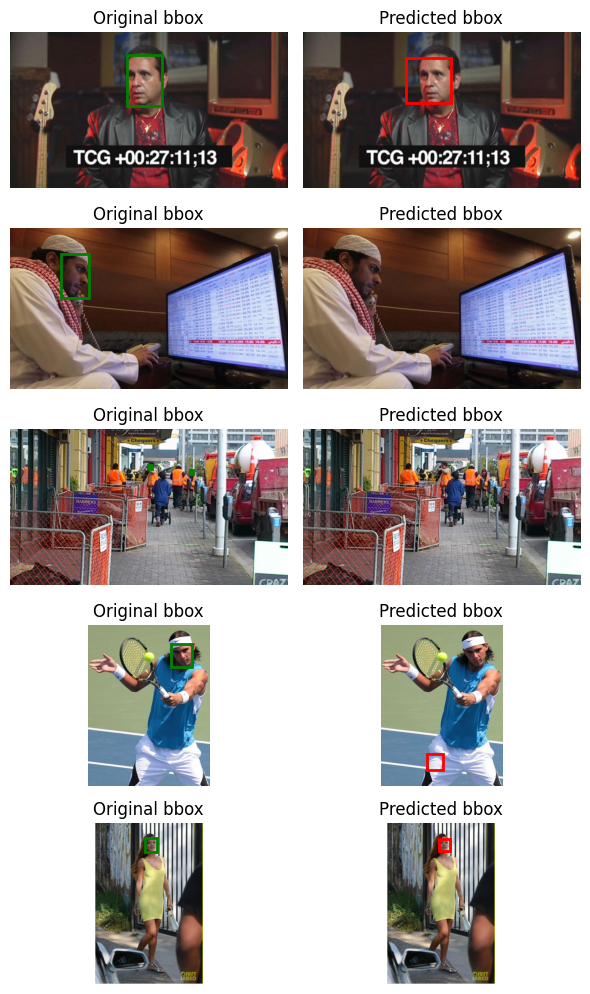

In [8]:
seed_everything(2)
draw_predicted_bboxes(dataset, dfs['validation'], predictions, n_images=5)

# Подбор гиперпараметров

In [11]:
def predict_batch(model, batch_size):
    original_cols = ['img_id', 'label', 'xmin', 'xmax', 'ymin', 'ymax']
    preds_cols = ['img_id', 'label', "confidence", 'xmin', 'xmax', 'ymin', 'ymax']

    idx = random.sample(dfs["train"]['img_id'].unique().tolist(), k=batch_size)
    batch = dataset["train"][idx]
    
    images = list(map(np.array, batch['image']))
    original = dfs['train'].query("img_id in @idx")
    preds = model.predict(images, idx=np.array(idx))
    preds = pd.DataFrame(preds)

    if preds.empty:
        return 0.0
    
    mean_ap, average_precisions = mean_average_precision_for_boxes(
        original[original_cols].values,
        preds[preds_cols].values,
    )
    return mean_ap

In [12]:
def objective(trial, batch_size):
    
    predict_params = {
        "scaleFactor": trial.suggest_float("scaleFactor", 1.01, 3.0),
        "minNeighbors": trial.suggest_int("minNeighbors", 1, 15),
        "minSize": (
            trial.suggest_int("minSize1", 10, 100), 
            trial.suggest_int("minSize2", 10, 100)
        ),
    }
    model = Cascade(predict_params=predict_params)
    mean_ap = predict_batch(model, batch_size)
    return mean_ap

In [13]:
batch_size, n_trials = 100, 100

study = optuna.create_study(direction='maximize')
study.optimize(
    partial(objective, batch_size=batch_size), 
    n_trials=n_trials,
)

[I 2024-06-02 03:20:35,838] A new study created in memory with name: no-name-f419cfad-abe8-427f-a81e-1c6a7d5c4324
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 62.32it/s]
[I 2024-06-02 03:20:38,381] Trial 0 finished with value: 0.24444444444444444 and parameters: {'scaleFactor': 1.1879639183074295, 'minNeighbors': 10, 'minSize1': 81, 'minSize2': 57}. Best is trial 0 with value: 0.24444444444444444.


Number of files in annotations: 100
Number of files in predictions: 32
Unique classes: 1
Detections length: 32
Annotations length: 100
face                           | 0.244444 |     135
mAP: 0.244444


100%|█████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]
[I 2024-06-02 03:21:42,612] Trial 1 finished with value: 0.23170275778956012 and parameters: {'scaleFactor': 1.0255740775726674, 'minNeighbors': 12, 'minSize1': 15, 'minSize2': 16}. Best is trial 0 with value: 0.24444444444444444.


Number of files in annotations: 100
Number of files in predictions: 87
Unique classes: 1
Detections length: 87
Annotations length: 100
face                           | 0.231703 |     126
mAP: 0.231703


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 58.62it/s]
[I 2024-06-02 03:21:44,999] Trial 2 finished with value: 0.269865573384635 and parameters: {'scaleFactor': 1.305078795814843, 'minNeighbors': 6, 'minSize1': 34, 'minSize2': 83}. Best is trial 2 with value: 0.269865573384635.


Number of files in annotations: 100
Number of files in predictions: 36
Unique classes: 1
Detections length: 36
Annotations length: 100
face                           | 0.269866 |     121
mAP: 0.269866


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 254.64it/s]
[I 2024-06-02 03:21:46,044] Trial 3 finished with value: 0.07936507936507936 and parameters: {'scaleFactor': 2.5801646940352265, 'minNeighbors': 10, 'minSize1': 85, 'minSize2': 74}. Best is trial 2 with value: 0.269865573384635.


Number of files in annotations: 100
Number of files in predictions: 10
Unique classes: 1
Detections length: 10
Annotations length: 100
face                           | 0.079365 |     126
mAP: 0.079365


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 201.18it/s]
[I 2024-06-02 03:21:47,218] Trial 4 finished with value: 0.12638888888888888 and parameters: {'scaleFactor': 2.43787436267747, 'minNeighbors': 6, 'minSize1': 69, 'minSize2': 35}. Best is trial 2 with value: 0.269865573384635.


Number of files in annotations: 100
Number of files in predictions: 17
Unique classes: 1
Detections length: 17
Annotations length: 100
face                           | 0.126389 |     124
mAP: 0.126389


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 41.70it/s]
[I 2024-06-02 03:21:50,346] Trial 5 finished with value: 0.273571281204869 and parameters: {'scaleFactor': 1.7095427095992568, 'minNeighbors': 6, 'minSize1': 30, 'minSize2': 18}. Best is trial 5 with value: 0.273571281204869.


Number of files in annotations: 100
Number of files in predictions: 32
Unique classes: 1
Detections length: 32
Annotations length: 100
face                           | 0.273571 |     131
mAP: 0.273571


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 119.55it/s]
[I 2024-06-02 03:21:51,850] Trial 6 finished with value: 0.2691908028720173 and parameters: {'scaleFactor': 1.7067923465963761, 'minNeighbors': 5, 'minSize1': 68, 'minSize2': 86}. Best is trial 5 with value: 0.273571281204869.


Number of files in annotations: 100
Number of files in predictions: 37
Unique classes: 1
Detections length: 37
Annotations length: 100
face                           | 0.269191 |     124
mAP: 0.269191


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.29it/s]
[I 2024-06-02 03:21:54,391] Trial 7 finished with value: 0.12874356119597424 and parameters: {'scaleFactor': 2.33138202622215, 'minNeighbors': 1, 'minSize1': 35, 'minSize2': 14}. Best is trial 5 with value: 0.273571281204869.


Number of files in annotations: 100
Number of files in predictions: 64
Unique classes: 1
Detections length: 64
Annotations length: 100
face                           | 0.128744 |     133
mAP: 0.128744


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.48it/s]
[I 2024-06-02 03:21:56,581] Trial 8 finished with value: 0.15388759116427755 and parameters: {'scaleFactor': 2.6221073276028575, 'minNeighbors': 2, 'minSize1': 16, 'minSize2': 60}. Best is trial 5 with value: 0.273571281204869.


Number of files in annotations: 100
Number of files in predictions: 39
Unique classes: 1
Detections length: 39
Annotations length: 100
face                           | 0.153888 |     131
mAP: 0.153888


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.95it/s]
[I 2024-06-02 03:22:02,016] Trial 9 finished with value: 0.34416091954022987 and parameters: {'scaleFactor': 1.291233775660794, 'minNeighbors': 4, 'minSize1': 22, 'minSize2': 50}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 51
Unique classes: 1
Detections length: 51
Annotations length: 100
face                           | 0.344161 |     125
mAP: 0.344161


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.32it/s]
[I 2024-06-02 03:22:04,052] Trial 10 finished with value: 0.031007751937984496 and parameters: {'scaleFactor': 2.999832510070966, 'minNeighbors': 14, 'minSize1': 50, 'minSize2': 39}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 4
Unique classes: 1
Detections length: 4
Annotations length: 100
face                           | 0.031008 |     129
mAP: 0.031008


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 45.10it/s]
[I 2024-06-02 03:22:06,979] Trial 11 finished with value: 0.2722125790875791 and parameters: {'scaleFactor': 1.6898215641688081, 'minNeighbors': 4, 'minSize1': 28, 'minSize2': 39}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 40
Unique classes: 1
Detections length: 40
Annotations length: 100
face                           | 0.272213 |     120
mAP: 0.272213


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 41.56it/s]
[I 2024-06-02 03:22:10,069] Trial 12 finished with value: 0.21302884615384618 and parameters: {'scaleFactor': 1.5741817737066106, 'minNeighbors': 8, 'minSize1': 49, 'minSize2': 29}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 29
Unique classes: 1
Detections length: 29
Annotations length: 100
face                           | 0.213029 |     130
mAP: 0.213029


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 230.04it/s]
[I 2024-06-02 03:22:11,200] Trial 13 finished with value: 0.2028225806451613 and parameters: {'scaleFactor': 1.925434745199473, 'minNeighbors': 3, 'minSize1': 25, 'minSize2': 100}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 27
Unique classes: 1
Detections length: 27
Annotations length: 100
face                           | 0.202823 |     124
mAP: 0.202823


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.73it/s]
[I 2024-06-02 03:22:16,230] Trial 14 finished with value: 0.18287373045760585 and parameters: {'scaleFactor': 1.4377835165811539, 'minNeighbors': 8, 'minSize1': 42, 'minSize2': 50}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 25
Unique classes: 1
Detections length: 25
Annotations length: 100
face                           | 0.182874 |     127
mAP: 0.182874


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.75it/s]
[I 2024-06-02 03:22:20,526] Trial 15 finished with value: 0.16888150609080843 and parameters: {'scaleFactor': 2.148001728005758, 'minNeighbors': 6, 'minSize1': 16, 'minSize2': 24}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 22
Unique classes: 1
Detections length: 22
Annotations length: 100
face                           | 0.168882 |     129
mAP: 0.168882


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 206.54it/s]
[I 2024-06-02 03:22:21,714] Trial 16 finished with value: 0.24983236793420743 and parameters: {'scaleFactor': 1.9055888297254044, 'minNeighbors': 4, 'minSize1': 98, 'minSize2': 10}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 31
Unique classes: 1
Detections length: 31
Annotations length: 100
face                           | 0.249832 |     121
mAP: 0.249832


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.94it/s]
[I 2024-06-02 03:22:26,622] Trial 17 finished with value: 0.14708195037654462 and parameters: {'scaleFactor': 1.4389751972709997, 'minNeighbors': 1, 'minSize1': 25, 'minSize2': 48}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 86
Unique classes: 1
Detections length: 86
Annotations length: 100
face                           | 0.147082 |     131
mAP: 0.147082


100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  7.89it/s]
[I 2024-06-02 03:22:39,978] Trial 18 finished with value: 0.2560779838182092 and parameters: {'scaleFactor': 1.0432035353992732, 'minNeighbors': 10, 'minSize1': 59, 'minSize2': 67}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 65
Unique classes: 1
Detections length: 65
Annotations length: 100
face                           | 0.256078 |     126
mAP: 0.256078


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 40.77it/s]
[I 2024-06-02 03:22:43,170] Trial 19 finished with value: 0.16602354388613927 and parameters: {'scaleFactor': 2.0901386728137346, 'minNeighbors': 7, 'minSize1': 40, 'minSize2': 23}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 24
Unique classes: 1
Detections length: 24
Annotations length: 100
face                           | 0.166024 |     131
mAP: 0.166024


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 65.92it/s]
[I 2024-06-02 03:22:45,339] Trial 20 finished with value: 0.21549479166666669 and parameters: {'scaleFactor': 1.7694737956441555, 'minNeighbors': 3, 'minSize1': 11, 'minSize2': 49}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 41
Unique classes: 1
Detections length: 41
Annotations length: 100
face                           | 0.215495 |     128
mAP: 0.215495


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 33.20it/s]
[I 2024-06-02 03:22:49,058] Trial 21 finished with value: 0.21308493833601438 and parameters: {'scaleFactor': 1.5194519114563823, 'minNeighbors': 4, 'minSize1': 26, 'minSize2': 40}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 34
Unique classes: 1
Detections length: 34
Annotations length: 100
face                           | 0.213085 |     132
mAP: 0.213085


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 39.48it/s]
[I 2024-06-02 03:22:52,303] Trial 22 finished with value: 0.2089144199346405 and parameters: {'scaleFactor': 1.6979697894990342, 'minNeighbors': 4, 'minSize1': 30, 'minSize2': 32}. Best is trial 9 with value: 0.34416091954022987.


Number of files in annotations: 100
Number of files in predictions: 31
Unique classes: 1
Detections length: 31
Annotations length: 100
face                           | 0.208914 |     128
mAP: 0.208914


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.64it/s]
[I 2024-06-02 03:22:57,299] Trial 23 finished with value: 0.4135414317569955 and parameters: {'scaleFactor': 1.2560571401864045, 'minNeighbors': 5, 'minSize1': 21, 'minSize2': 43}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 53
Unique classes: 1
Detections length: 53
Annotations length: 100
face                           | 0.413541 |     124
mAP: 0.413541


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 30.73it/s]
[I 2024-06-02 03:23:01,215] Trial 24 finished with value: 0.2676321881091618 and parameters: {'scaleFactor': 1.2812386352850338, 'minNeighbors': 8, 'minSize1': 20, 'minSize2': 60}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 33
Unique classes: 1
Detections length: 33
Annotations length: 100
face                           | 0.267632 |     128
mAP: 0.267632


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.37it/s]
[I 2024-06-02 03:23:08,078] Trial 25 finished with value: 0.2993917206012704 and parameters: {'scaleFactor': 1.1831266900975985, 'minNeighbors': 5, 'minSize1': 41, 'minSize2': 44}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 61
Unique classes: 1
Detections length: 61
Annotations length: 100
face                           | 0.299392 |     126
mAP: 0.299392


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 24.21it/s]
[I 2024-06-02 03:23:12,901] Trial 26 finished with value: 0.25315392829053096 and parameters: {'scaleFactor': 1.2569444965282186, 'minNeighbors': 3, 'minSize1': 39, 'minSize2': 44}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 57
Unique classes: 1
Detections length: 57
Annotations length: 100
face                           | 0.253154 |     124
mAP: 0.253154


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 25.42it/s]
[I 2024-06-02 03:23:17,555] Trial 27 finished with value: 0.29529169155857693 and parameters: {'scaleFactor': 1.150257797396344, 'minNeighbors': 5, 'minSize1': 45, 'minSize2': 66}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 52
Unique classes: 1
Detections length: 52
Annotations length: 100
face                           | 0.295292 |     126
mAP: 0.295292


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.48it/s]
[I 2024-06-02 03:23:21,125] Trial 28 finished with value: 0.2772150221994104 and parameters: {'scaleFactor': 1.3876259410844003, 'minNeighbors': 2, 'minSize1': 56, 'minSize2': 56}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 59
Unique classes: 1
Detections length: 59
Annotations length: 100
face                           | 0.277215 |     123
mAP: 0.277215


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.80it/s]
[I 2024-06-02 03:23:29,107] Trial 29 finished with value: 0.34885903294005316 and parameters: {'scaleFactor': 1.127768800373721, 'minNeighbors': 9, 'minSize1': 20, 'minSize2': 53}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 52
Unique classes: 1
Detections length: 52
Annotations length: 100
face                           | 0.348859 |     129
mAP: 0.348859


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.80it/s]
[I 2024-06-02 03:23:34,724] Trial 30 finished with value: 0.34979342232828703 and parameters: {'scaleFactor': 1.1418197517092046, 'minNeighbors': 12, 'minSize1': 10, 'minSize2': 67}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 43
Unique classes: 1
Detections length: 43
Annotations length: 100
face                           | 0.349793 |     125
mAP: 0.349793


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.72it/s]
[I 2024-06-02 03:23:39,793] Trial 31 finished with value: 0.3321621368979686 and parameters: {'scaleFactor': 1.121297442004719, 'minNeighbors': 12, 'minSize1': 10, 'minSize2': 69}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 45
Unique classes: 1
Detections length: 45
Annotations length: 100
face                           | 0.332162 |     121
mAP: 0.332162


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.65it/s]
[I 2024-06-02 03:23:55,498] Trial 32 finished with value: 0.33666184649307485 and parameters: {'scaleFactor': 1.0605035829331142, 'minNeighbors': 12, 'minSize1': 21, 'minSize2': 53}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 65
Unique classes: 1
Detections length: 65
Annotations length: 100
face                           | 0.336662 |     127
mAP: 0.336662


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 66.59it/s]
[I 2024-06-02 03:23:57,684] Trial 33 finished with value: 0.140625 and parameters: {'scaleFactor': 1.3181987825235244, 'minNeighbors': 15, 'minSize1': 20, 'minSize2': 77}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 18
Unique classes: 1
Detections length: 18
Annotations length: 100
face                           | 0.140625 |     128
mAP: 0.140625


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]
[I 2024-06-02 03:24:22,482] Trial 34 finished with value: 0.2512241508479339 and parameters: {'scaleFactor': 1.0288182507961554, 'minNeighbors': 11, 'minSize1': 13, 'minSize2': 61}. Best is trial 23 with value: 0.4135414317569955.


Number of files in annotations: 100
Number of files in predictions: 75
Unique classes: 1
Detections length: 75
Annotations length: 100
face                           | 0.251224 |     125
mAP: 0.251224


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.83it/s]
[I 2024-06-02 03:24:27,776] Trial 35 finished with value: 0.43808880529973104 and parameters: {'scaleFactor': 1.2060636484816092, 'minNeighbors': 9, 'minSize1': 34, 'minSize2': 54}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 55
Unique classes: 1
Detections length: 55
Annotations length: 100
face                           | 0.438089 |     128
mAP: 0.438089


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 84.00it/s]
[I 2024-06-02 03:24:29,740] Trial 36 finished with value: 0.14516129032258066 and parameters: {'scaleFactor': 1.5768293899587156, 'minNeighbors': 9, 'minSize1': 33, 'minSize2': 76}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 18
Unique classes: 1
Detections length: 18
Annotations length: 100
face                           | 0.145161 |     124
mAP: 0.145161


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 46.94it/s]
[I 2024-06-02 03:24:32,614] Trial 37 finished with value: 0.26319176319176324 and parameters: {'scaleFactor': 1.2146192203843997, 'minNeighbors': 13, 'minSize1': 16, 'minSize2': 89}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 36
Unique classes: 1
Detections length: 36
Annotations length: 100
face                           | 0.263192 |     126
mAP: 0.263192


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.34it/s]
[I 2024-06-02 03:24:36,264] Trial 38 finished with value: 0.18900240384615385 and parameters: {'scaleFactor': 1.3726937217777315, 'minNeighbors': 11, 'minSize1': 33, 'minSize2': 56}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 24
Unique classes: 1
Detections length: 24
Annotations length: 100
face                           | 0.189002 |     128
mAP: 0.189002


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.87it/s]
[I 2024-06-02 03:24:41,311] Trial 39 finished with value: 0.34108527131782945 and parameters: {'scaleFactor': 1.147552044145744, 'minNeighbors': 11, 'minSize1': 63, 'minSize2': 71}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 40
Unique classes: 1
Detections length: 40
Annotations length: 100
face                           | 0.341085 |     129
mAP: 0.341085


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 67.48it/s]
[I 2024-06-02 03:24:43,467] Trial 40 finished with value: 0.13570019723865878 and parameters: {'scaleFactor': 1.5123880168692914, 'minNeighbors': 9, 'minSize1': 74, 'minSize2': 44}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 17
Unique classes: 1
Detections length: 17
Annotations length: 100
face                           | 0.135700 |     130
mAP: 0.135700


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 42.75it/s]
[I 2024-06-02 03:24:46,521] Trial 41 finished with value: 0.3006888847514429 and parameters: {'scaleFactor': 1.2740802485802112, 'minNeighbors': 7, 'minSize1': 18, 'minSize2': 64}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 38
Unique classes: 1
Detections length: 38
Annotations length: 100
face                           | 0.300689 |     131
mAP: 0.300689


100%|█████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]
[I 2024-06-02 03:25:38,128] Trial 42 finished with value: 0.11704711558329854 and parameters: {'scaleFactor': 1.0201311376563706, 'minNeighbors': 9, 'minSize1': 22, 'minSize2': 51}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 91
Unique classes: 1
Detections length: 91
Annotations length: 100
face                           | 0.117047 |     128
mAP: 0.117047


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.91it/s]
[I 2024-06-02 03:25:42,379] Trial 43 finished with value: 0.2790076335877862 and parameters: {'scaleFactor': 1.3519668190260363, 'minNeighbors': 7, 'minSize1': 13, 'minSize2': 35}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 36
Unique classes: 1
Detections length: 36
Annotations length: 100
face                           | 0.279008 |     131
mAP: 0.279008


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.19it/s]
[I 2024-06-02 03:25:47,788] Trial 44 finished with value: 0.31680821553427574 and parameters: {'scaleFactor': 1.2051940319221366, 'minNeighbors': 10, 'minSize1': 24, 'minSize2': 60}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 40
Unique classes: 1
Detections length: 40
Annotations length: 100
face                           | 0.316808 |     129
mAP: 0.316808


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.89it/s]
[I 2024-06-02 03:25:55,175] Trial 45 finished with value: 0.35312556107486975 and parameters: {'scaleFactor': 1.120769745542739, 'minNeighbors': 13, 'minSize1': 29, 'minSize2': 55}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 46
Unique classes: 1
Detections length: 46
Annotations length: 100
face                           | 0.353126 |     124
mAP: 0.353126


100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.07it/s]
[I 2024-06-02 03:26:04,116] Trial 46 finished with value: 0.37069507513762834 and parameters: {'scaleFactor': 1.1118715997426856, 'minNeighbors': 13, 'minSize1': 30, 'minSize2': 55}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 46
Unique classes: 1
Detections length: 46
Annotations length: 100
face                           | 0.370695 |     125
mAP: 0.370695


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.61it/s]
[I 2024-06-02 03:26:10,611] Trial 47 finished with value: 0.3318077803203661 and parameters: {'scaleFactor': 1.1192816351199228, 'minNeighbors': 14, 'minSize1': 37, 'minSize2': 63}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 41
Unique classes: 1
Detections length: 41
Annotations length: 100
face                           | 0.331808 |     133
mAP: 0.331808


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 293.80it/s]
[I 2024-06-02 03:26:11,676] Trial 48 finished with value: 0.04838709677419355 and parameters: {'scaleFactor': 2.803472301550138, 'minNeighbors': 13, 'minSize1': 30, 'minSize2': 83}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 6
Unique classes: 1
Detections length: 6
Annotations length: 100
face                           | 0.048387 |     124
mAP: 0.048387


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 50.13it/s]
[I 2024-06-02 03:26:14,308] Trial 49 finished with value: 0.06870229007633588 and parameters: {'scaleFactor': 1.4507828434500403, 'minNeighbors': 15, 'minSize1': 33, 'minSize2': 72}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 8
Unique classes: 1
Detections length: 8
Annotations length: 100
face                           | 0.068702 |     131
mAP: 0.068702


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 59.33it/s]
[I 2024-06-02 03:26:16,654] Trial 50 finished with value: 0.04779411764705882 and parameters: {'scaleFactor': 2.4688852441601115, 'minNeighbors': 13, 'minSize1': 28, 'minSize2': 46}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 7
Unique classes: 1
Detections length: 7
Annotations length: 100
face                           | 0.047794 |     136
mAP: 0.047794


100%|█████████████████████████████████████████| 100/100 [00:10<00:00,  9.48it/s]
[I 2024-06-02 03:26:27,918] Trial 51 finished with value: 0.35429223565916146 and parameters: {'scaleFactor': 1.0884016375865424, 'minNeighbors': 14, 'minSize1': 17, 'minSize2': 54}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 46
Unique classes: 1
Detections length: 46
Annotations length: 100
face                           | 0.354292 |     131
mAP: 0.354292


100%|█████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]
[I 2024-06-02 03:27:34,644] Trial 52 finished with value: 0.14336052278450523 and parameters: {'scaleFactor': 1.0101943105753401, 'minNeighbors': 14, 'minSize1': 17, 'minSize2': 57}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 85
Unique classes: 1
Detections length: 85
Annotations length: 100
face                           | 0.143361 |     127
mAP: 0.143361


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.91it/s]
[I 2024-06-02 03:27:40,555] Trial 53 finished with value: 0.24481658692185007 and parameters: {'scaleFactor': 1.224570442010486, 'minNeighbors': 14, 'minSize1': 10, 'minSize2': 41}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 32
Unique classes: 1
Detections length: 32
Annotations length: 100
face                           | 0.244817 |     132
mAP: 0.244817


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.67it/s]
[I 2024-06-02 03:27:49,083] Trial 54 finished with value: 0.3192122463020296 and parameters: {'scaleFactor': 1.0946675174244263, 'minNeighbors': 12, 'minSize1': 48, 'minSize2': 57}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 50
Unique classes: 1
Detections length: 50
Annotations length: 100
face                           | 0.319212 |     136
mAP: 0.319212


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.86it/s]
[I 2024-06-02 03:27:53,482] Trial 55 finished with value: 0.234375 and parameters: {'scaleFactor': 1.3367374047910674, 'minNeighbors': 13, 'minSize1': 26, 'minSize2': 36}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 27
Unique classes: 1
Detections length: 27
Annotations length: 100
face                           | 0.234375 |     128
mAP: 0.234375


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 18.62it/s]
[I 2024-06-02 03:27:59,500] Trial 56 finished with value: 0.21514976958525348 and parameters: {'scaleFactor': 1.2131769864386142, 'minNeighbors': 15, 'minSize1': 14, 'minSize2': 52}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 26
Unique classes: 1
Detections length: 26
Annotations length: 100
face                           | 0.215150 |     124
mAP: 0.215150


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 86.97it/s]
[I 2024-06-02 03:28:01,331] Trial 57 finished with value: 0.14615384615384616 and parameters: {'scaleFactor': 1.5864242632918109, 'minNeighbors': 11, 'minSize1': 28, 'minSize2': 64}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 19
Unique classes: 1
Detections length: 19
Annotations length: 100
face                           | 0.146154 |     130
mAP: 0.146154


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.40it/s]
[I 2024-06-02 03:28:05,582] Trial 58 finished with value: 0.09230769230769231 and parameters: {'scaleFactor': 1.435624878265816, 'minNeighbors': 12, 'minSize1': 37, 'minSize2': 48}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 12
Unique classes: 1
Detections length: 12
Annotations length: 100
face                           | 0.092308 |     130
mAP: 0.092308


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.61it/s]
[I 2024-06-02 03:28:10,737] Trial 59 finished with value: 0.4180327868852459 and parameters: {'scaleFactor': 1.0922518220261213, 'minNeighbors': 13, 'minSize1': 90, 'minSize2': 59}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 47
Unique classes: 1
Detections length: 47
Annotations length: 100
face                           | 0.418033 |     122
mAP: 0.418033


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 148.25it/s]
[I 2024-06-02 03:28:12,076] Trial 60 finished with value: 0.056 and parameters: {'scaleFactor': 2.2346006145962005, 'minNeighbors': 14, 'minSize1': 94, 'minSize2': 46}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 6
Unique classes: 1
Detections length: 6
Annotations length: 100
face                           | 0.056000 |     125
mAP: 0.056000


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.04it/s]
[I 2024-06-02 03:28:17,498] Trial 61 finished with value: 0.34226225042862674 and parameters: {'scaleFactor': 1.0831360661653504, 'minNeighbors': 13, 'minSize1': 85, 'minSize2': 58}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 39
Unique classes: 1
Detections length: 39
Annotations length: 100
face                           | 0.342262 |     123
mAP: 0.342262


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.10it/s]
[I 2024-06-02 03:28:21,864] Trial 62 finished with value: 0.2748235294117646 and parameters: {'scaleFactor': 1.1602813179726557, 'minNeighbors': 13, 'minSize1': 79, 'minSize2': 54}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 33
Unique classes: 1
Detections length: 33
Annotations length: 100
face                           | 0.274824 |     125
mAP: 0.274824


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.81it/s]
[I 2024-06-02 03:28:25,513] Trial 63 finished with value: 0.22794117647058823 and parameters: {'scaleFactor': 1.3013250427398924, 'minNeighbors': 14, 'minSize1': 44, 'minSize2': 61}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 29
Unique classes: 1
Detections length: 29
Annotations length: 100
face                           | 0.227941 |     136
mAP: 0.227941


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.04it/s]
[I 2024-06-02 03:28:32,850] Trial 64 finished with value: 0.4091739218790108 and parameters: {'scaleFactor': 1.0864439244607818, 'minNeighbors': 15, 'minSize1': 23, 'minSize2': 67}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 47
Unique classes: 1
Detections length: 47
Annotations length: 100
face                           | 0.409174 |     128
mAP: 0.409174


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.42it/s]
[I 2024-06-02 03:28:45,356] Trial 65 finished with value: 0.3974608304153759 and parameters: {'scaleFactor': 1.0808198822472541, 'minNeighbors': 15, 'minSize1': 30, 'minSize2': 50}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 53
Unique classes: 1
Detections length: 53
Annotations length: 100
face                           | 0.397461 |     132
mAP: 0.397461


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 58.39it/s]
[I 2024-06-02 03:28:47,737] Trial 66 finished with value: 0.048 and parameters: {'scaleFactor': 1.826963122963135, 'minNeighbors': 15, 'minSize1': 23, 'minSize2': 41}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 6
Unique classes: 1
Detections length: 6
Annotations length: 100
face                           | 0.048000 |     125
mAP: 0.048000


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 36.39it/s]
[I 2024-06-02 03:28:51,131] Trial 67 finished with value: 0.2193384223918575 and parameters: {'scaleFactor': 1.2561418682221093, 'minNeighbors': 15, 'minSize1': 66, 'minSize2': 49}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 27
Unique classes: 1
Detections length: 27
Annotations length: 100
face                           | 0.219338 |     131
mAP: 0.219338


100%|█████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]
[I 2024-06-02 03:29:13,044] Trial 68 finished with value: 0.37812961531502726 and parameters: {'scaleFactor': 1.0557050925558553, 'minNeighbors': 14, 'minSize1': 36, 'minSize2': 26}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 68
Unique classes: 1
Detections length: 68
Annotations length: 100
face                           | 0.378130 |     135
mAP: 0.378130


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.40it/s]
[I 2024-06-02 03:29:29,351] Trial 69 finished with value: 0.3460752688172043 and parameters: {'scaleFactor': 1.0587630985876606, 'minNeighbors': 15, 'minSize1': 53, 'minSize2': 24}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 57
Unique classes: 1
Detections length: 57
Annotations length: 100
face                           | 0.346075 |     124
mAP: 0.346075


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.81it/s]
[I 2024-06-02 03:29:36,342] Trial 70 finished with value: 0.26957323172183856 and parameters: {'scaleFactor': 1.1877329771420688, 'minNeighbors': 6, 'minSize1': 37, 'minSize2': 36}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 57
Unique classes: 1
Detections length: 57
Annotations length: 100
face                           | 0.269573 |     130
mAP: 0.269573


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]
[I 2024-06-02 03:29:52,373] Trial 71 finished with value: 0.29431423199671375 and parameters: {'scaleFactor': 1.0834164436581921, 'minNeighbors': 14, 'minSize1': 32, 'minSize2': 11}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 51
Unique classes: 1
Detections length: 51
Annotations length: 100
face                           | 0.294314 |     137
mAP: 0.294314


100%|█████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]
[I 2024-06-02 03:31:46,779] Trial 72 finished with value: 0.19026944477789462 and parameters: {'scaleFactor': 1.0140292761811245, 'minNeighbors': 15, 'minSize1': 25, 'minSize2': 20}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 88
Unique classes: 1
Detections length: 88
Annotations length: 100
face                           | 0.190269 |     123
mAP: 0.190269


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.12it/s]
[I 2024-06-02 03:31:51,754] Trial 73 finished with value: 0.311130007558579 and parameters: {'scaleFactor': 1.2390556973917404, 'minNeighbors': 14, 'minSize1': 18, 'minSize2': 51}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 39
Unique classes: 1
Detections length: 39
Annotations length: 100
face                           | 0.311130 |     126
mAP: 0.311130


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.77it/s]
[I 2024-06-02 03:31:56,838] Trial 74 finished with value: 0.30120448750637424 and parameters: {'scaleFactor': 1.0785406857713284, 'minNeighbors': 14, 'minSize1': 92, 'minSize2': 28}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 40
Unique classes: 1
Detections length: 40
Annotations length: 100
face                           | 0.301204 |     125
mAP: 0.301204


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 20.00it/s]
[I 2024-06-02 03:32:02,503] Trial 75 finished with value: 0.26870860042735045 and parameters: {'scaleFactor': 1.1685082086906446, 'minNeighbors': 15, 'minSize1': 27, 'minSize2': 59}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 35
Unique classes: 1
Detections length: 35
Annotations length: 100
face                           | 0.268709 |     120
mAP: 0.268709


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 62.85it/s]
[I 2024-06-02 03:32:04,815] Trial 76 finished with value: 0.13043478260869568 and parameters: {'scaleFactor': 1.3806957040138936, 'minNeighbors': 14, 'minSize1': 36, 'minSize2': 66}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 16
Unique classes: 1
Detections length: 16
Annotations length: 100
face                           | 0.130435 |     138
mAP: 0.130435


100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 22.76it/s]
[I 2024-06-02 03:32:09,885] Trial 77 finished with value: 0.23063180827886712 and parameters: {'scaleFactor': 1.3030367639750082, 'minNeighbors': 13, 'minSize1': 42, 'minSize2': 16}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 30
Unique classes: 1
Detections length: 30
Annotations length: 100
face                           | 0.230632 |     135
mAP: 0.230632


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.77it/s]
[I 2024-06-02 03:32:18,390] Trial 78 finished with value: 0.27261660369125185 and parameters: {'scaleFactor': 1.1777925623587069, 'minNeighbors': 12, 'minSize1': 31, 'minSize2': 31}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 36
Unique classes: 1
Detections length: 36
Annotations length: 100
face                           | 0.272617 |     122
mAP: 0.272617


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.94it/s]
[I 2024-06-02 03:32:24,667] Trial 79 finished with value: 0.2977993135473452 and parameters: {'scaleFactor': 1.2605502385077212, 'minNeighbors': 15, 'minSize1': 22, 'minSize2': 46}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 36
Unique classes: 1
Detections length: 36
Annotations length: 100
face                           | 0.297799 |     127
mAP: 0.297799


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.82it/s]
[I 2024-06-02 03:32:34,602] Trial 80 finished with value: 0.38775997006468305 and parameters: {'scaleFactor': 1.0781641831558089, 'minNeighbors': 14, 'minSize1': 39, 'minSize2': 62}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 56
Unique classes: 1
Detections length: 56
Annotations length: 100
face                           | 0.387760 |     127
mAP: 0.387760


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 12.76it/s]
[I 2024-06-02 03:32:43,151] Trial 81 finished with value: 0.16145196714256774 and parameters: {'scaleFactor': 1.0987392253497803, 'minNeighbors': 2, 'minSize1': 39, 'minSize2': 62}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 86
Unique classes: 1
Detections length: 86
Annotations length: 100
face                           | 0.161452 |     130
mAP: 0.161452


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.96it/s]
[I 2024-06-02 03:32:54,954] Trial 82 finished with value: 0.34588235294117653 and parameters: {'scaleFactor': 1.0494578311229217, 'minNeighbors': 14, 'minSize1': 35, 'minSize2': 69}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 61
Unique classes: 1
Detections length: 61
Annotations length: 100
face                           | 0.345882 |     135
mAP: 0.345882


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.78it/s]
[I 2024-06-02 03:33:01,659] Trial 83 finished with value: 0.28767006231300535 and parameters: {'scaleFactor': 1.1364278214781027, 'minNeighbors': 5, 'minSize1': 44, 'minSize2': 54}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 54
Unique classes: 1
Detections length: 54
Annotations length: 100
face                           | 0.287670 |     127
mAP: 0.287670


100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.38it/s]
[I 2024-06-02 03:33:12,009] Trial 84 finished with value: 0.30992855383099277 and parameters: {'scaleFactor': 1.0504831162918773, 'minNeighbors': 13, 'minSize1': 30, 'minSize2': 74}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 52
Unique classes: 1
Detections length: 52
Annotations length: 100
face                           | 0.309929 |     123
mAP: 0.309929


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 116.47it/s]
[I 2024-06-02 03:33:13,528] Trial 85 finished with value: 0.01639344262295082 and parameters: {'scaleFactor': 2.002753697011004, 'minNeighbors': 15, 'minSize1': 19, 'minSize2': 58}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 2
Unique classes: 1
Detections length: 2
Annotations length: 100
face                           | 0.016393 |     122
mAP: 0.016393


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.25it/s]
[I 2024-06-02 03:33:18,051] Trial 86 finished with value: 0.26229508196721313 and parameters: {'scaleFactor': 1.219621698322627, 'minNeighbors': 14, 'minSize1': 24, 'minSize2': 64}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 31
Unique classes: 1
Detections length: 31
Annotations length: 100
face                           | 0.262295 |     122
mAP: 0.262295


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 14.45it/s]
[I 2024-06-02 03:33:25,636] Trial 87 finished with value: 0.30357402881065065 and parameters: {'scaleFactor': 1.1314295758830264, 'minNeighbors': 13, 'minSize1': 34, 'minSize2': 55}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 44
Unique classes: 1
Detections length: 44
Annotations length: 100
face                           | 0.303574 |     134
mAP: 0.303574


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.49it/s]
[I 2024-06-02 03:33:29,711] Trial 88 finished with value: 0.23351935458111078 and parameters: {'scaleFactor': 1.1769159175425246, 'minNeighbors': 6, 'minSize1': 48, 'minSize2': 69}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 41
Unique classes: 1
Detections length: 41
Annotations length: 100
face                           | 0.233519 |     137
mAP: 0.233519


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  9.03it/s]
[I 2024-06-02 03:33:41,457] Trial 89 finished with value: 0.2115984290355889 and parameters: {'scaleFactor': 1.0911670945121548, 'minNeighbors': 7, 'minSize1': 15, 'minSize2': 51}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 64
Unique classes: 1
Detections length: 64
Annotations length: 100
face                           | 0.211598 |     134
mAP: 0.211598


100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]
[I 2024-06-02 03:34:43,696] Trial 90 finished with value: 0.12280755269036521 and parameters: {'scaleFactor': 1.0118241205480172, 'minNeighbors': 10, 'minSize1': 57, 'minSize2': 43}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 91
Unique classes: 1
Detections length: 91
Annotations length: 100
face                           | 0.122808 |     128
mAP: 0.122808


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.06it/s]
[I 2024-06-02 03:34:52,057] Trial 91 finished with value: 0.35992871766183676 and parameters: {'scaleFactor': 1.116452025681536, 'minNeighbors': 13, 'minSize1': 29, 'minSize2': 55}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 48
Unique classes: 1
Detections length: 48
Annotations length: 100
face                           | 0.359929 |     134
mAP: 0.359929


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.22it/s]
[I 2024-06-02 03:34:57,952] Trial 92 finished with value: 0.2696032388663968 and parameters: {'scaleFactor': 1.2826032584559093, 'minNeighbors': 12, 'minSize1': 31, 'minSize2': 48}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 36
Unique classes: 1
Detections length: 36
Annotations length: 100
face                           | 0.269603 |     130
mAP: 0.269603


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 15.81it/s]
[I 2024-06-02 03:35:04,995] Trial 93 finished with value: 0.4027137042062415 and parameters: {'scaleFactor': 1.126593818840195, 'minNeighbors': 14, 'minSize1': 27, 'minSize2': 59}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 43
Unique classes: 1
Detections length: 43
Annotations length: 100
face                           | 0.402714 |     134
mAP: 0.402714


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.83it/s]
[I 2024-06-02 03:35:09,452] Trial 94 finished with value: 0.2717695740951555 and parameters: {'scaleFactor': 1.1948634045375628, 'minNeighbors': 8, 'minSize1': 27, 'minSize2': 62}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 40
Unique classes: 1
Detections length: 40
Annotations length: 100
face                           | 0.271770 |     129
mAP: 0.271770


100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 16.76it/s]
[I 2024-06-02 03:35:16,107] Trial 95 finished with value: 0.35742858077650874 and parameters: {'scaleFactor': 1.1260631203222389, 'minNeighbors': 13, 'minSize1': 39, 'minSize2': 59}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 43
Unique classes: 1
Detections length: 43
Annotations length: 100
face                           | 0.357429 |     122
mAP: 0.357429


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 44.26it/s]
[I 2024-06-02 03:35:19,140] Trial 96 finished with value: 0.24 and parameters: {'scaleFactor': 1.3348084942133247, 'minNeighbors': 14, 'minSize1': 35, 'minSize2': 66}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 26
Unique classes: 1
Detections length: 26
Annotations length: 100
face                           | 0.240000 |     125
mAP: 0.240000


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 43.02it/s]
[I 2024-06-02 03:35:22,197] Trial 97 finished with value: 0.068 and parameters: {'scaleFactor': 1.4111286205733908, 'minNeighbors': 15, 'minSize1': 21, 'minSize2': 56}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 9
Unique classes: 1
Detections length: 9
Annotations length: 100
face                           | 0.068000 |     125
mAP: 0.068000


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 64.05it/s]
[I 2024-06-02 03:35:24,441] Trial 98 finished with value: 0.07345454545454545 and parameters: {'scaleFactor': 1.49211147611586, 'minNeighbors': 13, 'minSize1': 28, 'minSize2': 80}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 10
Unique classes: 1
Detections length: 10
Annotations length: 100
face                           | 0.073455 |     125
mAP: 0.073455


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 46.65it/s]
[I 2024-06-02 03:35:27,266] Trial 99 finished with value: 0.03968253968253968 and parameters: {'scaleFactor': 1.6353815319024152, 'minNeighbors': 14, 'minSize1': 32, 'minSize2': 52}. Best is trial 35 with value: 0.43808880529973104.


Number of files in annotations: 100
Number of files in predictions: 5
Unique classes: 1
Detections length: 5
Annotations length: 100
face                           | 0.039683 |     126
mAP: 0.039683


In [20]:
cascade = Cascade(predict_params={
    "scaleFactor": 1.21,
    "minNeighbors": 9,
    "minSize": (34, 54),
})

predictions = []
split = "validation"
for idx in trange(len(dataset[split])):
    img = np.array(dataset[split][idx]['image'])
    
    faces = cascade.predict(
        images=np.expand_dims(img, 0), 
        idx=np.array([idx]),
    )
    predictions.extend(faces)

predictions = pd.DataFrame(predictions)

100%|███████████████████████████████████████| 1537/1537 [01:11<00:00, 21.37it/s]


In [21]:
original_cols = ['img_id', 'label', 'xmin', 'xmax', 'ymin', 'ymax']
preds_cols = ['img_id', 'label', "confidence", 'xmin', 'xmax', 'ymin', 'ymax']
mean_ap, average_precisions = mean_average_precision_for_boxes(
    dfs["validation"][original_cols].values,
    predictions[preds_cols].values,
)

Number of files in annotations: 1537
Number of files in predictions: 608
Unique classes: 1
Detections length: 608
Annotations length: 1537
face                           | 0.315401 |    1952
mAP: 0.315401


In [18]:
predictions.to_csv(DATA_PATH / "preds-validation.csv", index=False)

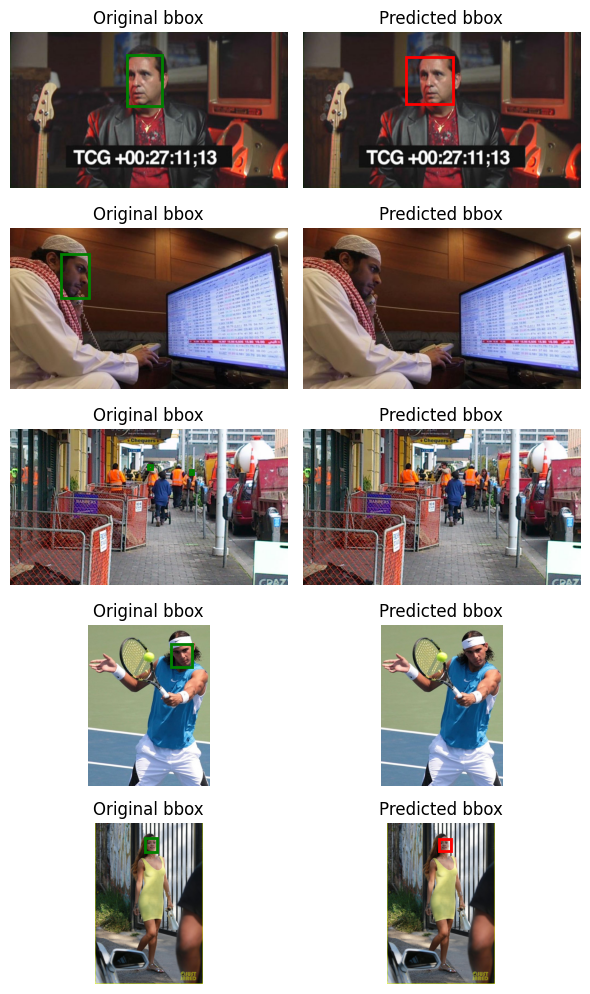

In [19]:
seed_everything(2)
draw_predicted_bboxes(dataset, dfs['validation'], predictions, n_images=5)